In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pyproj
import pygmt
import eqs_magnetics as eqs
import itertools
import synthetics
import warnings

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
icegrav = pd.read_table(
    '../data/ICEGRAV_Mag_2013_v2.XYZ',
    delim_whitespace=True,
    na_values="*",
    dtype={'Line_Number':str}
)
icegrav.dropna(subset=('Lon', 'Lat'), inplace=True)

In [4]:
projection = pyproj.Proj(projparams='+proj=ups +south', preserve_units=False)
x,y = projection(icegrav.Lon, icegrav.Lat)
coordinates = [x, y]
coordinates.append(np.full_like(coordinates[0], icegrav.Height_WGS1984))

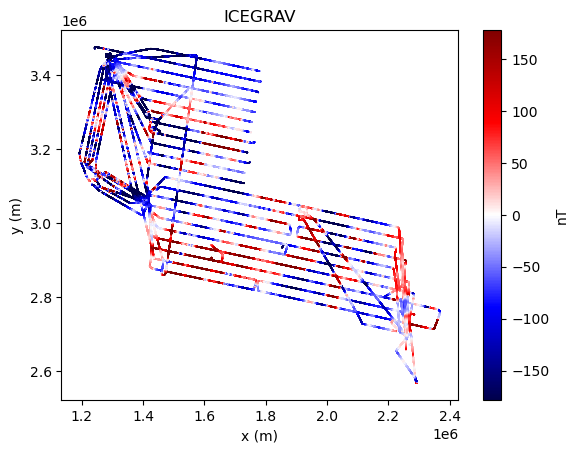

In [5]:
plt.figure()
scale = np.nanpercentile(icegrav.MagL, 95)
plt.scatter(*coordinates[:2], c=icegrav.MagL, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
plt.title("ICEGRAV")
plt.show()

In [6]:
field_direction = eqs.angles_to_vector(-65, -25, 1)

In [54]:
dipole_moments = []
source_coordinates = []
source_coordinates.append([[1.45e6], [3.5e6], [-3e3]])
dipole_moments.append(eqs.angles_to_vector(-80, 60, 1e14))

source_coordinates.append([[1.3e6], [3.46e6], [-3e3]])
dipole_moments.append(eqs.angles_to_vector(-80, 60, 1e14))

source_coordinates.append([[1.38e6], [3.39e6], [-100]])
dipole_moments.append(eqs.angles_to_vector(60, 60, 1.5e13))

source_coordinates.append([[1.52e6], [3.39e6], [-1e3]])
dipole_moments.append(eqs.angles_to_vector(-70, 60, 5e13))
source_coordinates.append([[1.54e6], [3.39e6], [-1e3]])
dipole_moments.append(eqs.angles_to_vector(-70, 60, 5e13))
source_coordinates.append([[1.56e6], [3.39e6], [-1e3]])
dipole_moments.append(eqs.angles_to_vector(-70, 60, 5e13))
source_coordinates.append([[1.58e6], [3.39e6], [-1e3]])
dipole_moments.append(eqs.angles_to_vector(-70, 60, 5e13))
source_coordinates.append([[1.6e6], [3.39e6], [-1e3]])
dipole_moments.append(eqs.angles_to_vector(-70, 60, 5e13))

source_coordinates.append(vd.profile_coordinates((1.32e6,3.25e6),(1.42e6,3.32e6), size=8, extra_coords=-200)[0])
dipole_moments.append(eqs.angles_to_vector(-50, 70, np.full(8, 5e12)))

source_coordinates.append([[1.65e6], [3.22e6], [-100]])
dipole_moments.append(eqs.angles_to_vector(60, 60, 5e13))

source_coordinates.append(vd.profile_coordinates((1.2e6,3.25e6),(1.3e6,3.15e6), size=8, extra_coords=-500)[0])
dipole_moments.append(eqs.angles_to_vector(-50, 70, np.full(8, 1e13)))

source_coordinates.append([[1.5e6], [3.2e6], [-1e3]])
dipole_moments.append(eqs.angles_to_vector(-80, 60, 3e14))

source_coordinates.append([[1.6e6], [3.1e6], [-300]])
dipole_moments.append(eqs.angles_to_vector(-80, 60, 5e13))

source_coordinates.append(vd.profile_coordinates((1.74e6,3.15e6),(1.85e6,3.4e6), size=15, extra_coords=-500)[0])
dipole_moments.append(eqs.angles_to_vector(-50, 70, np.full(15, 1e13)))

source_coordinates.append([[1.7e6], [3.1e6], [-1e3]])
dipole_moments.append(eqs.angles_to_vector(-80, 60, 1e14))

source_coordinates.append([[1.39e6], [3.07e6], [-3e3]])
dipole_moments.append(eqs.angles_to_vector(-80, 60, 1e14))

source_coordinates.append([[1.52e6], [3.05e6], [-1e3]])
dipole_moments.append(eqs.angles_to_vector(-80, 60, 1e14))

source_coordinates.append(vd.profile_coordinates((1.7e6,3.05e6),(1.75e6,2.95e6), size=15, extra_coords=-200)[0])
dipole_moments.append(eqs.angles_to_vector(-50, 70, np.full(15, 1e12)))

source_coordinates.append([[1.85e6], [2.95e6], [400]])
dipole_moments.append(eqs.angles_to_vector(-80, 60, 1e14))

source_coordinates.append(vd.profile_coordinates((1.5e6,2.9e6),(1.65e6,2.95e6), size=15, extra_coords=-800)[0])
dipole_moments.append(eqs.angles_to_vector(60, 60, np.full(15, 5e12)))
source_coordinates.append(vd.profile_coordinates((1.6e6,2.9e6),(1.9e6,2.9e6), size=20, extra_coords=-800)[0])
dipole_moments.append(eqs.angles_to_vector(60, 60, np.full(20, 5e12)))

source_coordinates.append(vd.profile_coordinates((1.9e6,2.75e6),(2.05e6,3.05e6), size=20, extra_coords=-2e3)[0])
dipole_moments.append(eqs.angles_to_vector(-45, 70, np.full(20, 2e12)))
source_coordinates.append([[1.9e6], [2.82e6], [-2e3]])
dipole_moments.append(eqs.angles_to_vector(-45, 70, 8e13))
source_coordinates.append([[1.75e6], [2.8e6], [-2e3]])
dipole_moments.append(eqs.angles_to_vector(-45, 70, 8e13))
source_coordinates.append([[1.78e6], [2.8e6], [-2e3]])
dipole_moments.append(eqs.angles_to_vector(-45, 70, 8e13))

source_coordinates.append(vd.profile_coordinates((2.02e6,2.75e6),(2.1e6,3.95e6), size=20, extra_coords=-2e3)[0])
dipole_moments.append(eqs.angles_to_vector(70, 70, np.full(20, 8e12)))

source_coordinates.append(vd.profile_coordinates((2.1e6,2.75e6),(2.2e6,2.9e6), size=15, extra_coords=-2e3)[0])
dipole_moments.append(eqs.angles_to_vector(-50, 70, np.full(15, 5e12)))
source_coordinates.append(vd.profile_coordinates((2.2e6,2.6e6),(2.18e6,2.9e6), size=15, extra_coords=-2e3)[0])
dipole_moments.append(eqs.angles_to_vector(-50, 70, np.full(15, 5e12)))
source_coordinates.append([[2.15e6], [2.8e6], [-2e3]])
dipole_moments.append(eqs.angles_to_vector(-50, 60, 5e13))
source_coordinates.append([[2.15e6], [2.74e6], [-2e3]])
dipole_moments.append(eqs.angles_to_vector(-50, 60, 8e13))

source_coordinates.append(vd.profile_coordinates((2.21e6,3.0e6),(2.25e6,2.8e6), size=15, extra_coords=-5e3)[0])
dipole_moments.append(eqs.angles_to_vector(70, 70, np.full(15, 5e12)))

source_coordinates.append([[2.22e6], [2.6e6], [-1e3]])
dipole_moments.append(eqs.angles_to_vector(-80, 60, 1e14))

# regional
source_coordinates.append([np.asarray(c).ravel() for c in vd.grid_coordinates([1.2e6,2.5e6,2.5e6,3.25e6,], shape=(100,100), extra_coords=-50e3)])
dipole_moments.append(eqs.angles_to_vector(-70, -30, np.full(10000, 9e12)))

source_coordinates = np.concatenate(source_coordinates, axis=1)
dipole_moments = np.concatenate(dipole_moments, axis=1)

In [55]:
b_field = eqs.dipole_magnetic(coordinates, source_coordinates, dipole_moments)
tfa = eqs.total_field_anomaly(b_field, field_direction)
bnorm = eqs.magnetic_field_norm(b_field)

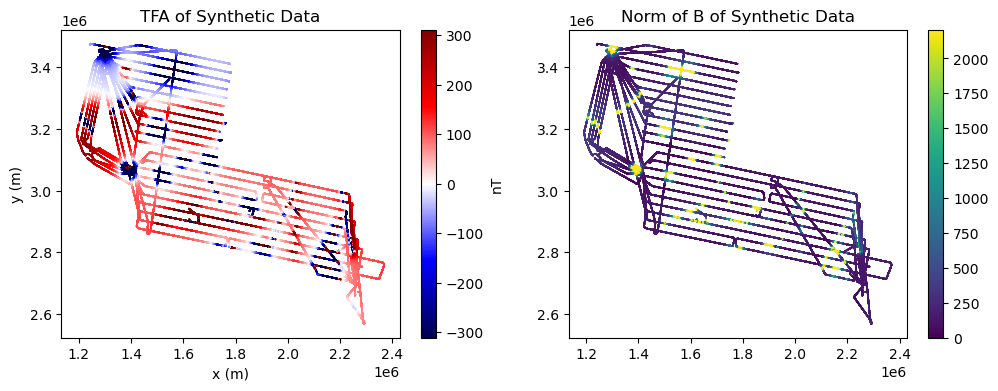

In [56]:
plt.figure(figsize=(12,4))
scale = np.nanpercentile(tfa, 95)
# scale = vd.maxabs(tfa)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
scale_bnorm = np.nanpercentile(bnorm, 95)
# scale_bnorm = vd.maxabs(bnorm)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=bnorm, cmap="viridis",s=0.01, vmin=0, vmax=scale_bnorm)
plt.title("Norm of B of Synthetic Data")
plt.colorbar()
plt.show()

## Fit deep sources

In [62]:
spacing = 5e4
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing, region=(vd.pad_region(vd.get_region(coordinates), pad=spacing*0.5)), drop_coords=False)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=tfa)

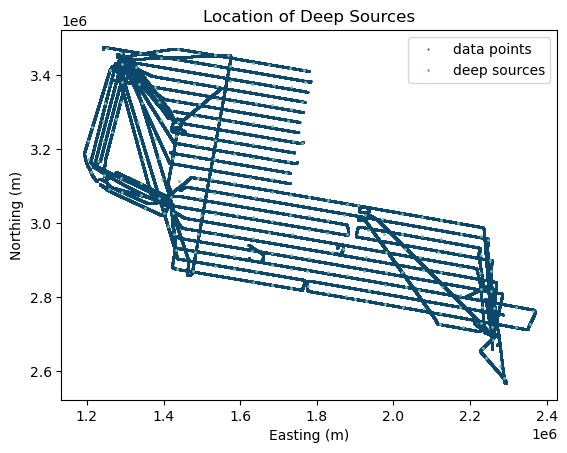

In [63]:
plt.figure()
plt.plot(*coordinates[:2], ".", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], ".", color="#79BD9A", markersize=2, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()

In [67]:
dampings_deep_eqs = [1e-3, 1e-2, 1e-1,]
spacing = np.mean(vd.median_distance(coords_blocked))
depths_deep_eqs = [spacing*2.5, spacing*4.25, spacing*6]
# dampings = [1e-3]
# depths = [spacing*4.25]

In [68]:
parameter_sets_deep_eqs = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_deep_eqs, depths_deep_eqs)
]
print("Number of combinations:", len(parameter_sets_deep_eqs))

Number of combinations: 9


In [69]:
%%time
kfold = vd.BlockKFold(
    spacing=2500,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores = []
for parameters in parameter_sets_deep_eqs:    
    print(parameters)
    eqs_deep = eqs.EquivalentSourcesMagnetic(block_size=1e4, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_blocked[test] - predicted))
    scores.append(np.mean(tmp))
    print(np.mean(tmp))

{'damping': 0.001, 'depth': 91779.65816847704}
933.1471523377826
{'damping': 0.001, 'depth': 156025.41888641095}
1047.1742282791915
{'damping': 0.001, 'depth': 220271.17960434488}
966.9738177768115
{'damping': 0.01, 'depth': 91779.65816847704}
932.3392240860788
{'damping': 0.01, 'depth': 156025.41888641095}
966.3556148050932
{'damping': 0.01, 'depth': 220271.17960434488}
973.5034710497778
{'damping': 0.1, 'depth': 91779.65816847704}
925.7246988932945
{'damping': 0.1, 'depth': 156025.41888641095}
936.3181149634759
{'damping': 0.1, 'depth': 220271.17960434488}
991.3310482786022
CPU times: user 1min 55s, sys: 48.2 s, total: 2min 43s
Wall time: 4.86 s


In [70]:
best = np.argmin(scores)
parameter_sets_deep_eqs[best]

{'damping': 0.1, 'depth': 91779.65816847704}

In [71]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets_deep_eqs[best])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -88895.50816847704
CPU times: user 780 ms, sys: 143 ms, total: 924 ms
Wall time: 27.1 ms


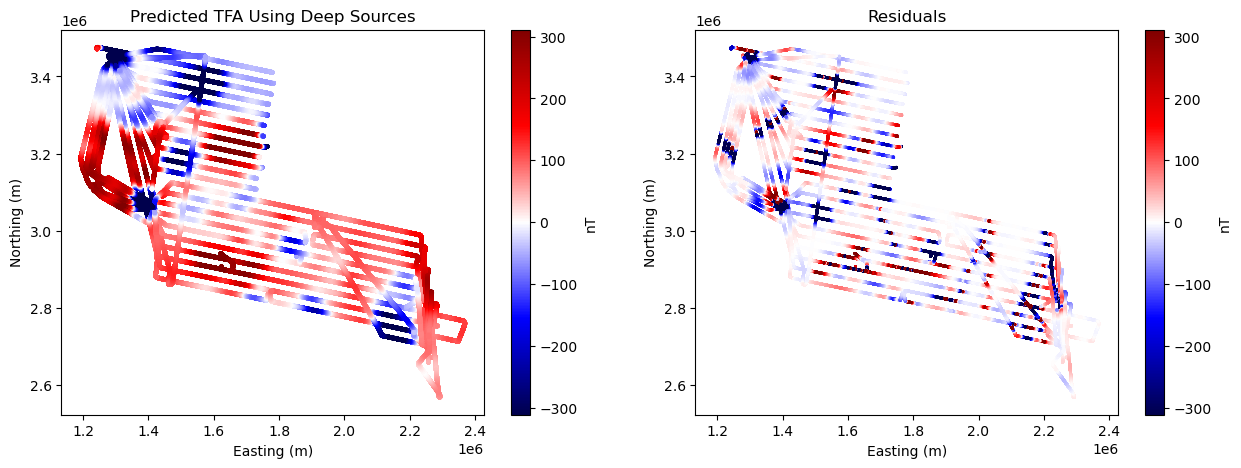

In [72]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = tfa - tfa_deep

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with gradient-boosted sources

In [73]:
dampings_shallow_eqs = [1e-3, 1e-2, 1e-1]
depths_shallow_eqs = [200, 400, 600, 800]

In [74]:
parameter_sets_shallow_eqs = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_shallow_eqs, depths_shallow_eqs)
]
print("Number of combinations:", len(parameter_sets_shallow_eqs))

Number of combinations: 12


In [75]:
%%time
kfold = vd.BlockKFold(
    spacing=1e5,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
for parameters in parameter_sets_shallow_eqs:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=1e3, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores.append(np.mean(tmp))
    print(np.mean(tmp))

{'damping': 0.001, 'depth': 200}
1123182.8198794131
{'damping': 0.001, 'depth': 400}
1122887.3375332237
{'damping': 0.001, 'depth': 600}
1123001.774279179
{'damping': 0.001, 'depth': 800}
1121957.6341725208
{'damping': 0.01, 'depth': 200}
1123182.8198833405
{'damping': 0.01, 'depth': 400}
1122887.3375257603
{'damping': 0.01, 'depth': 600}
1123001.774216187
{'damping': 0.01, 'depth': 800}
1121957.634110869
{'damping': 0.1, 'depth': 200}
1123182.8199222526
{'damping': 0.1, 'depth': 400}
1122887.3374286685
{'damping': 0.1, 'depth': 600}
1123001.773568558
{'damping': 0.1, 'depth': 800}
1121957.6338480897
CPU times: user 14h 45min 5s, sys: 2h 12min 22s, total: 16h 57min 27s
Wall time: 51min 29s


In [76]:
best = np.argmin(scores)
parameter_sets_shallow_eqs[best]

{'damping': 0.1, 'depth': 800}

In [77]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=1e3, **parameter_sets_shallow_eqs[best], repeat=2)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: 2099.5
window size: 114869.41642621873
CPU times: user 41min 20s, sys: 5min 28s, total: 46min 49s
Wall time: 2min 13s


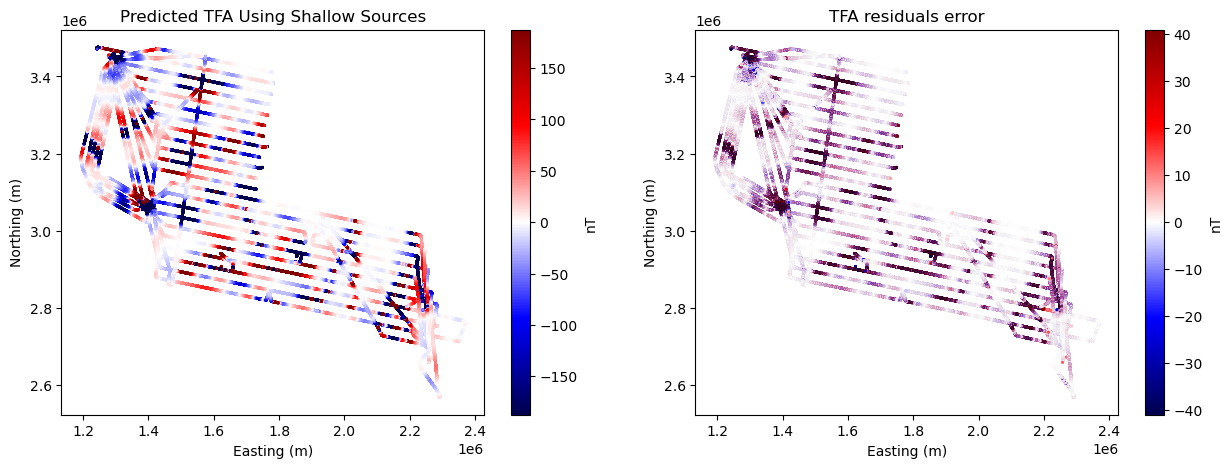

In [78]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
scale = np.nanpercentile(tfa_residuals_prediction, 95)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale = np.nanpercentile((tfa_residuals - tfa_residuals_prediction), 95)
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("TFA residuals error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Predict on a regular grid

In [79]:
grid_coordinates = vd.grid_coordinates(vd.get_region(coordinates), spacing=1e4, extra_coords=3e3)
true_b = eqs.dipole_magnetic(grid_coordinates, source_coordinates, dipole_moments)
predicted_b = eqs_deep.predict(grid_coordinates) + eqs_shallow.predict(grid_coordinates)

true_tfa = eqs.total_field_anomaly(true_b, field_direction)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = true_tfa - predicted_tfa

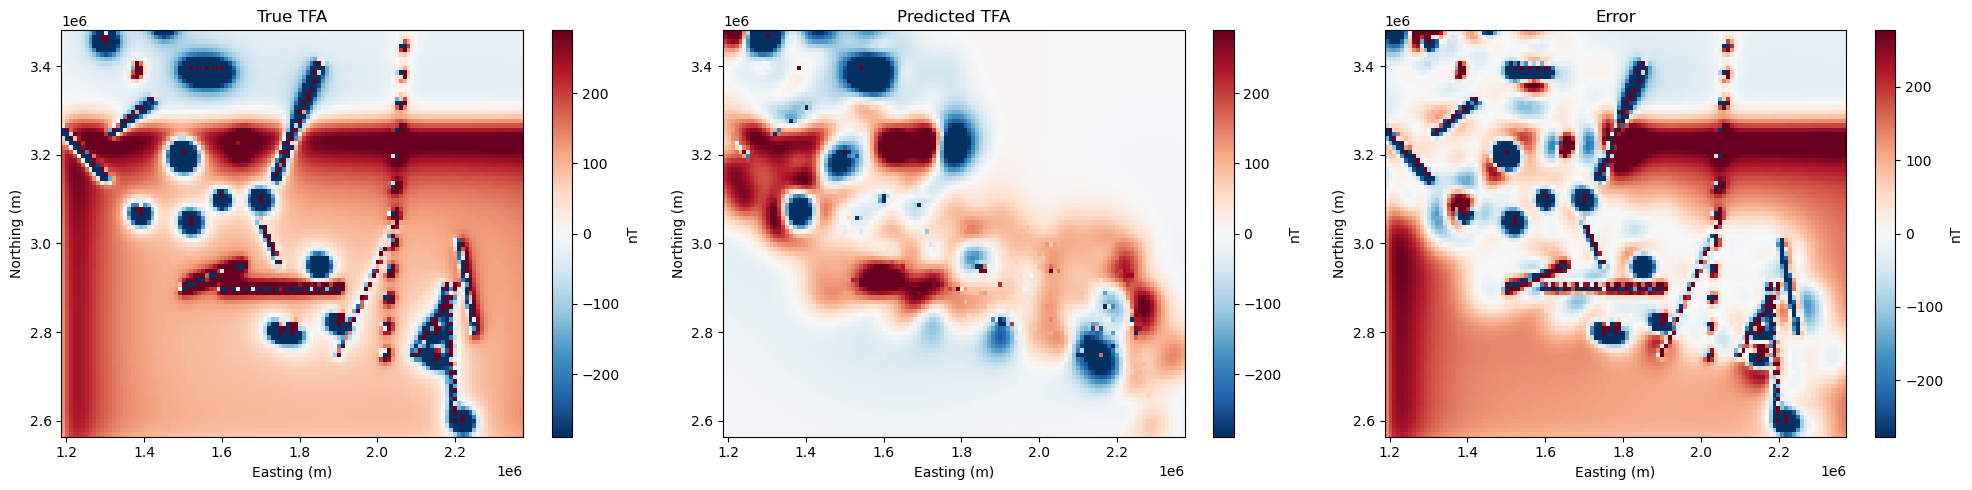

In [80]:
scale_tfa = np.nanpercentile(true_tfa, 95)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="RdBu_r", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_tfa, cmap="RdBu_r", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = np.nanpercentile(error_tfa, 95)
plt.pcolormesh(*grid_coordinates[:2], error_tfa, cmap="RdBu_r", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

In [81]:
true_norm_of_b = np.sqrt(sum(c**2 for c in true_b))
predicted_norm_of_b = np.sqrt(sum(c**2 for c in predicted_b))
error_norm_of_b = true_norm_of_b - predicted_norm_of_b

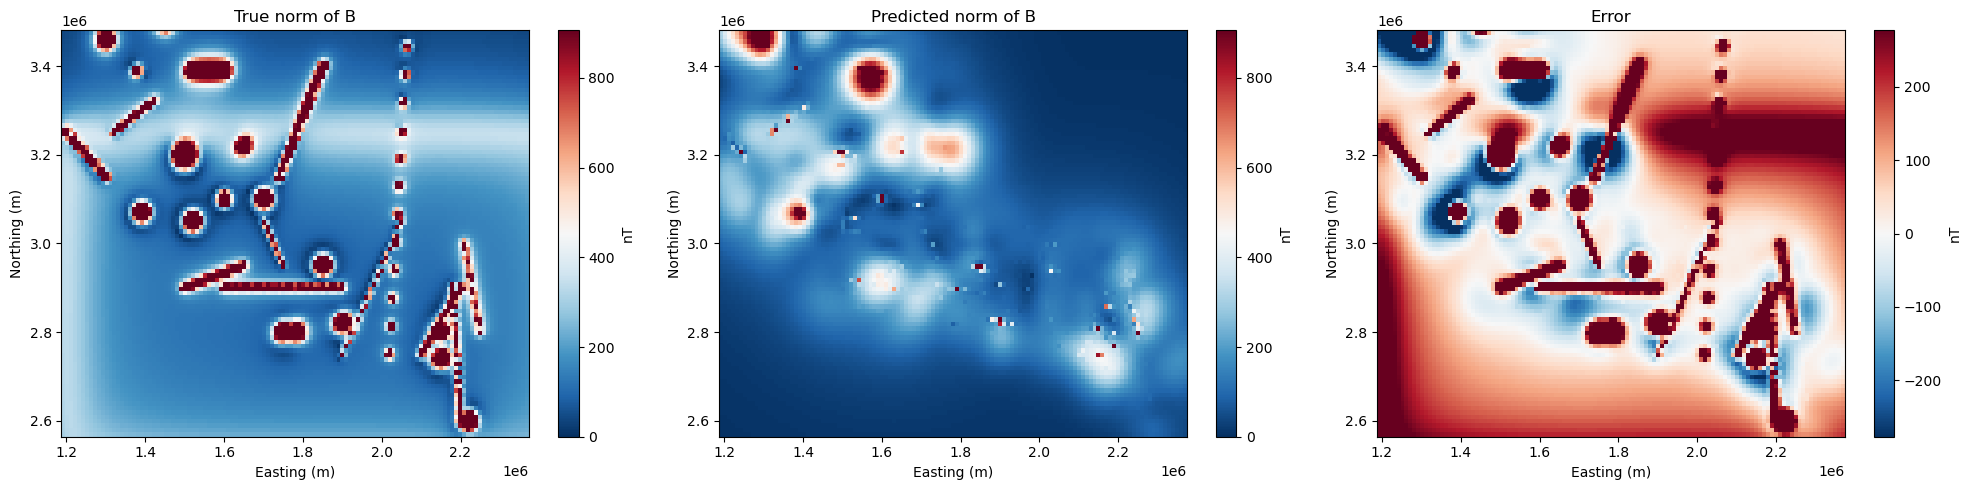

In [82]:
scale_b = np.nanpercentile(true_norm_of_b, 95)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_norm_of_b, cmap="RdBu_r", vmin=0, vmax=scale_b)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_norm_of_b, cmap="RdBu_r", vmin=0, vmax=scale_b)
plt.title("Predicted norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
np.nanpercentile(error_norm_of_b, 95)
plt.pcolormesh(*grid_coordinates[:2], error_norm_of_b, cmap="RdBu_r", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()